# Introduction

Weather data from SRRL and NSRDB will be compared for similar weather patterns.  The detect_clearsky method will also be used (based on SRRL data) and correlated with cloudy periods of time (NSRDB) to see if NSRDB data would be suitable as a training set for clear/cloudy skies.

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load SRRL and NSRDB data

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/ and NSRDB data is available at http://bit.ly/2oFzFMI.  NSRDB is not as up to date as SRRL, so we will just use 2014 (and sub-samples thereof) for analysis.

In [2]:
srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
nsrdb_file = os.path.expanduser('~/data_sets/nsrdb/SRRL_BMS_2010_global.csv')

In [3]:
srrl_data = pd.read_csv(srrl_file)

In [4]:
srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])

In [5]:
srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')

In [6]:
srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]

In [7]:
srrl_data = srrl_data.reindex(
    pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
).fillna(0)

In [8]:
srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)

In [9]:
nsrdb_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI', 'GHI', 'Cloud Type']

In [10]:
nsrdb_data = pd.read_csv(nsrdb_file, header=2, usecols=nsrdb_cols)

In [11]:
nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']] = \
    nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str)

In [12]:
nsrdb_data.index = pd.to_datetime(nsrdb_data['Year'] + '/' + 
                                  nsrdb_data['Month'] + '/' +
                                  nsrdb_data['Day'] + ' ' +
                                  nsrdb_data['Hour'] + ':' + 
                                  nsrdb_data['Minute'])

In [13]:
nsrdb_data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True, axis=1)

In [14]:
nsrdb_data.index = nsrdb_data.index.tz_localize('Etc/GMT+7')

In [15]:
nsrdb_data = nsrdb_data.reindex(
    pd.date_range(start=nsrdb_data.index[0], end=nsrdb_data.index[-1], freq='1min')
).fillna(method='ffill')

In [16]:
data = nsrdb_data.join(srrl_data)

In [17]:
data.head()

,DHI,DNI,GHI,Cloud Type,Global 40-South PSP [W/m^2],Global 40-South LI-200 [W/m^2]
2014-01-01 00:00:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:01:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:02:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:03:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:04:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN


# Set up PV_Lib clear sky detection

In [18]:
lat = 39.742
lon = -105.18
tilt = 40
azimuth = 180
elevation = 1828.8

system_noloc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
loc = pvlib.location.Location(lat, lon, altitude=elevation)
system_loc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=system_noloc, location=loc)

# Analysis function

We want to quanitify how well PVLib and NSRDB agree on cloudy/clear periods.  This agreement is defined as

## $A = \frac{1}{N_{\mathrm{CS}}} \sum_{i}^{N_{\text{CS}}} b_i c_i$

where $b_i$ represents PVLib clear sky (1 if clear, 0 if not) and $c_i$ represents NSRDB clear minutes (1 if clear, 0 if not).  $N_\text{CS}$ are the number of clear sky days (from either PVLIB or NSRDB classification).

In [19]:
def agreement_analysis(sample, sample_key, clear_skies, window=10, start_end=None, return_components=False, viz=True):
    # detect clear skies
    if return_components:
        is_clear, components, alpha = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                                     clear_skies, sample.index, window, 
                                                                     return_components=True)
        components = pd.DataFrame(components)
    else:
        is_clear = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                  clear_skies, sample.index, window)
    
    if start_end is not None:
        sample = sample.between_time(start_end[0], start_end[1])
        clear_skies = sample.between_time(start_end[0], start_end[1])
        is_clear = is_clear.between_time(start_end[0], start_end[1])

    # make mask dataframe
    mask = pd.DataFrame()
    mask ['pvlib'] = is_clear
    mask ['nsrdb'] = (sample['Cloud Type'] == 0)
    mask['consensus'] = mask['pvlib'] & mask['nsrdb']
    
    # calculate maximum and actual agreement between pvlib, nsrdb
    agree_val = mask['consensus'].sum() / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100
    min_val = min(mask['pvlib'].sum(), mask['nsrdb'].sum())
    max_agree_val = min_val / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100                               
    
    # plot findings
    if viz:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.5))

        _ = ax.plot(sample[sample_key].index, 
                sample[sample_key], label='GHI')

        _ = ax.scatter(sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])].index,
                   sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])], 
                   marker='o', edgecolor='red', facecolor='none', label='PVLib')

        _ = ax.scatter(sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])].index,
                   sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])],
                   marker='o', label='NSRDB', edgecolor='green', facecolor='none')

        _ = ax.scatter(sample[sample_key][mask['consensus']].index,
                   sample[sample_key][mask['consensus']], 
                   marker='o', label='Consensus', edgecolor='yellow', facecolor='none')

        _ = ax.set_ylabel('GHI W/m2')
        _ = ax.set_xlabel('Date and time')
        _ = ax.legend()

    if return_components:
        return {'mask': mask,
                'components': components,
                'alpha': alpha,
                'max_agreement': max_agree_val,
                'agreement': agree_val}
    else:
        return {'mask': mask,
                'max_agreement': max_agree_val,
                'agreement': agree_val}

# Investigate correlation of clear times

### Sample 1: January

In [20]:
start_date = '2014-01-01'
end_date = '2014-01-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [21]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/l

<IPython.core.display.Javascript object>


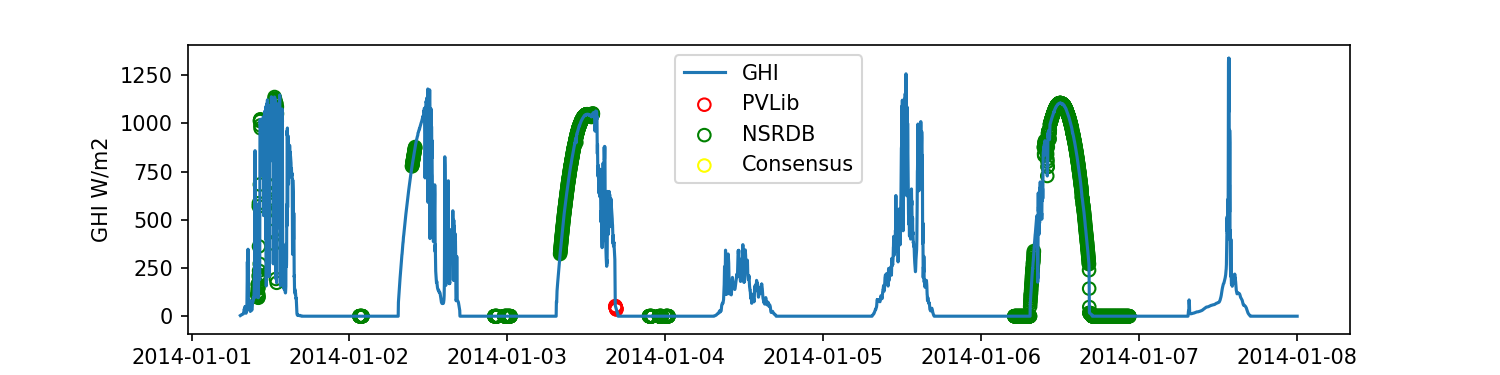

In [22]:
sample_dict = agreement_analysis(sample, 'Global 40-South LI-200 [W/m^2]',
                                 clear_skies['ghi'], return_components=True)

In [23]:
sample_dict['max_agreement'], sample_dict['agreement']

(0.61349693251533743, 0.0)

The PVLib clear sky method seriously struggles with this data set...  It should be investigated why this is happening.  It is a concerning sign not only for comparison of NSRDB data, but generalizability of PVLib detection.  This may be an artifact of poor default tolerances for the detect_clearsky method for this environment.  Trying a different sample to see how NSRDB and PVLib agree.   

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/l

<IPython.core.display.Javascript object>


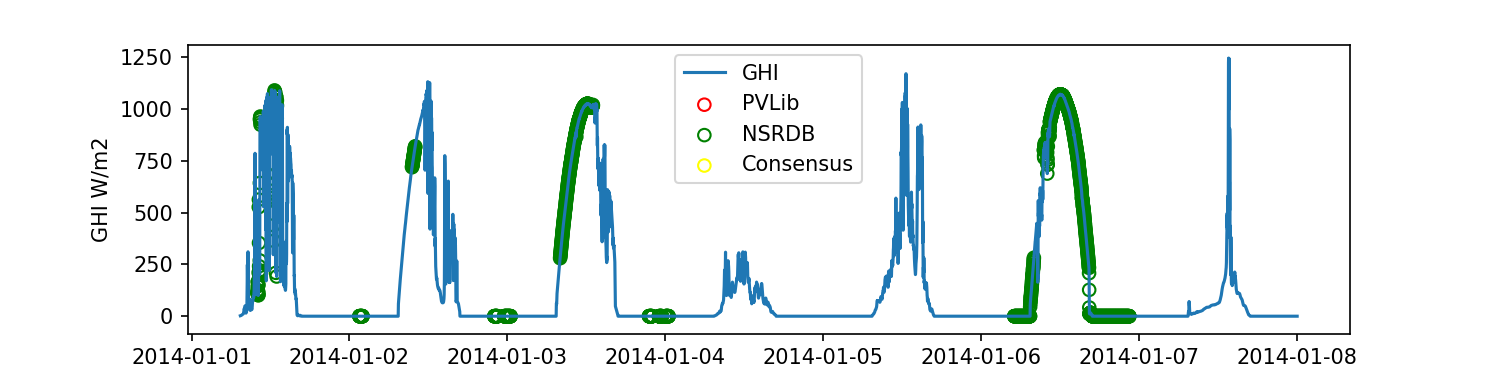

In [24]:
sample_dict = agreement_analysis(sample, 'Global 40-South PSP [W/m^2]',
                                 clear_skies['ghi'], return_components=True)

In [25]:
sample_dict['max_agreement'], sample_dict['agreement']

(0.0, 0.0)

<IPython.core.display.Javascript object>


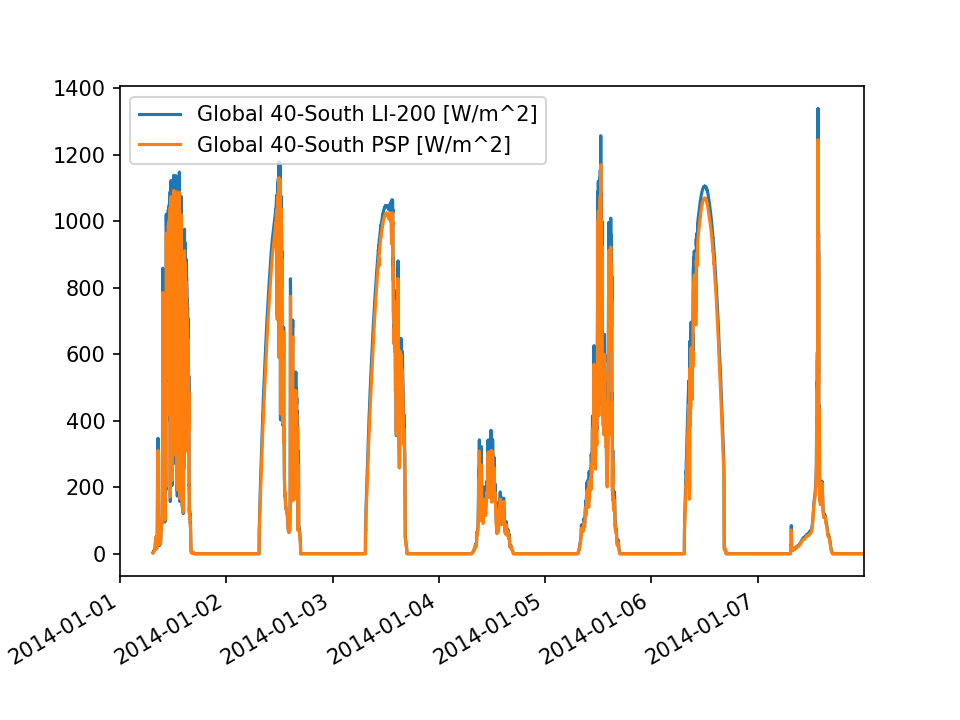

In [26]:
sample[['Global 40-South LI-200 [W/m^2]', 'Global 40-South PSP [W/m^2]']].plot()

The PSP detector fares worse than the LI detector for clear sky detection during this time period.  Again, this could likely be remedied by tuning the default tolerances.

### Sample 2: July

In [27]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [28]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


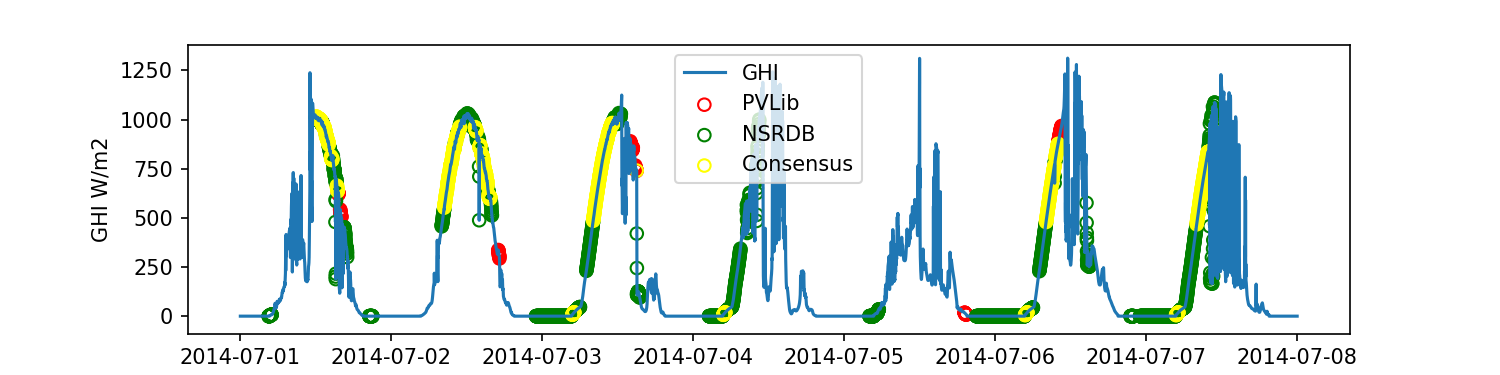

In [29]:
sample_dict = agreement_analysis(sample, 'Global 40-South LI-200 [W/m^2]', clear_skies['ghi'], return_components=True)

In [30]:
sample_dict['max_agreement'], sample_dict['agreement']

(26.852106857614981, 23.519691545028916)

The amount of agreement between PVLib and NSRDB is quite low at ~23.5% (with a potential maximum of ~26.9%).  It's interesting to note that many agreed upon times are also early in the morning or late in the day.  We also see that PVLib struggles on some periods where clear sky conditions look obvious (morning of July 3, morning of July 7).  We also see that during early mornings/late nights (with 0 irradiance), we are detecting clear skies using NSRDB.  These should be filtered out as PVLib will reject them automatically.

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


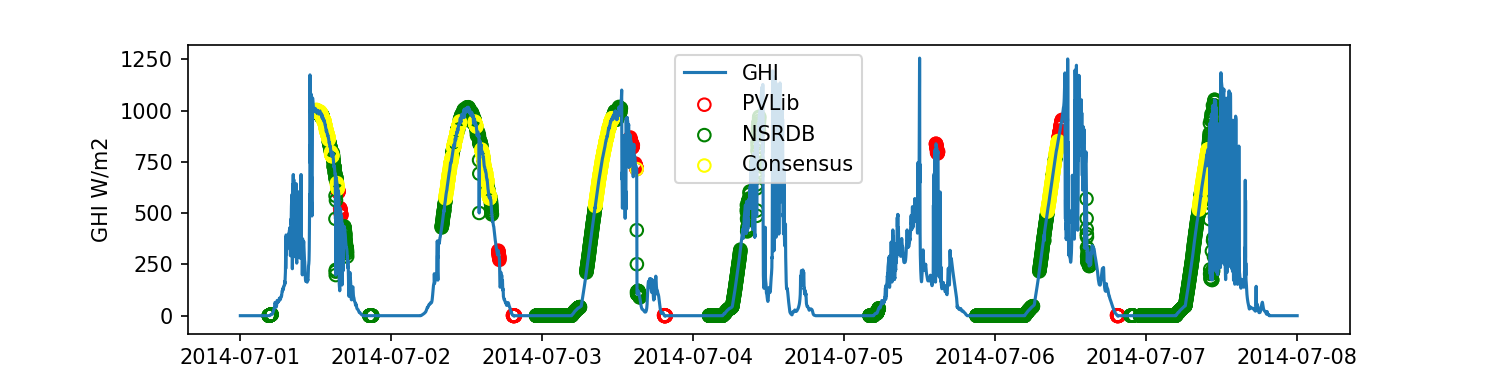

In [31]:
sample_dict = agreement_analysis(sample, 'Global 40-South PSP [W/m^2]', clear_skies['ghi'], return_components=True)

In [32]:
sample_dict['max_agreement'], sample_dict['agreement']

(23.020607375271148, 18.194143167028198)

The PSP detector is a worse candidate for detecting clear skies (for the given location and parameters).  Is has a lower maximum possible agreement and a lower actual agreeement between NSRDB and PVLib as well.

### Sample 2: July - restricting time of day

This is the same analysis as above,  except we restrict the time of day for detection (between 4:30AM and 10:00PM).  This is a very generous time frame, but we don't want to eleminate data that might be of interest.

In [33]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [34]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


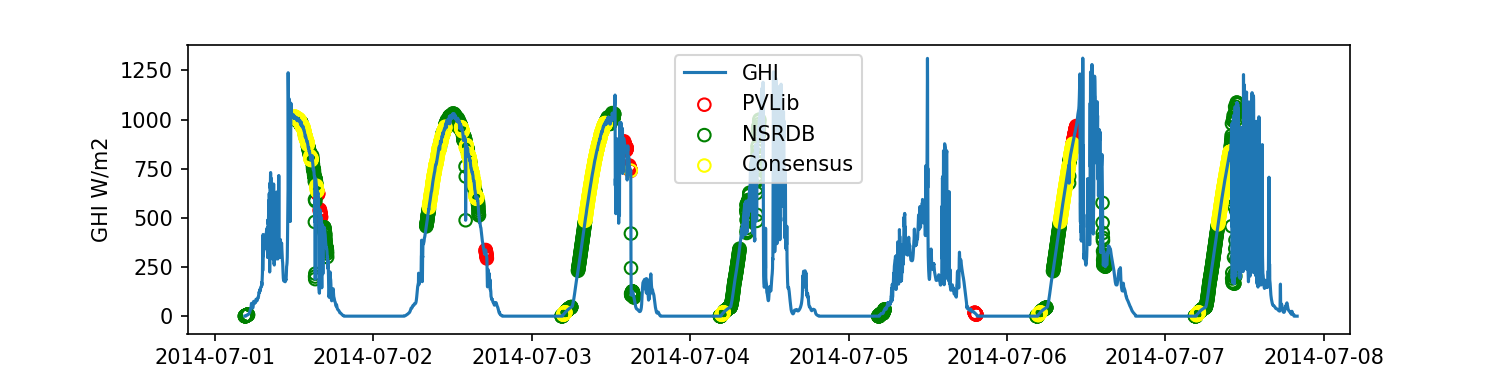

In [35]:
sample_dict = agreement_analysis(sample, 'Global 40-South LI-200 [W/m^2]', clear_skies['ghi'], start_end=('0430', '2000'))

We see that rejecting late nights/early mornings increases the agreement (and maximum possible agreement) between PVLib and NSRDB increases greatly to ~37%.  The maximum possible agreement also increases to ~42.2%.

It also looks like PVLib detect_clearsky only looks at lagged values.  Zooming in between 9:20 and 9:30AM on July 6 shows that up to the sharp dorp, PVLib detects clear sky, is affected by the zip for a series of 9 data points before clarity is once again found.  I would think the window should be centered on a given data point (say t=15 and window=10, t_interval = [10, 20]). 

### Sample 2: July - Set PVLib window equal to sample size of NSRBD (30min)

The NSRDB data set is only sampled every 30 min.  So far we have assumed that the data set needs no offsetting.  We have also been using only default parameters for clear sky detection, namely a 10min windown.  Here we will expand the window to 30 min to match the sampling of NSRDB.

In [36]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [37]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


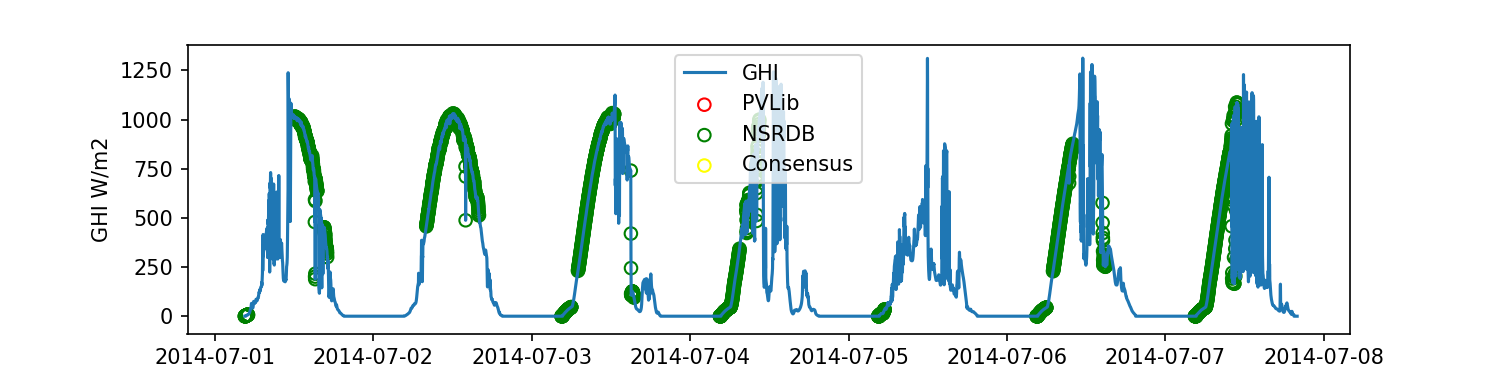

In [38]:
sample_dict = agreement_analysis(sample, 'Global 40-South LI-200 [W/m^2]', clear_skies['ghi'], start_end=('0430', '2000'), window=30)

We see that 30min is far too strict for the PVLib clear sky detection as no points are labelled clear.

# Outlook

PVLib struggled on this data set.  Both in January and with a 30 min window in July.  This is somewhat unexpected since previously the detection worked quite nicely.  Again, the generalizability of PVLib is called into question.  It is nice to see that there are points where both PVLib and NSRDB agree.  NSRDB seems to be too generous given the 30 min sampling it uses, so it's difficult to say how useful this data might be.  